In [17]:
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy import stats
import torch
import sys
sys.path.append('..')
from VAE.VAE_model import VAE
from scdesigner.simulators import NegBinCopulaSimulator as nbc
from scipy.sparse import csr_matrix, csc_matrix

load AE. Change the path of autoencoder to your local path

In [18]:
# modify the num_genes if use your own dataset
def load_VAE():
    autoencoder = VAE(
        num_genes=18996,
        device='mps',
        seed=0,
        loss_ae='mse',
        hidden_dim=128,
        decoder_activation='ReLU',
    )
    autoencoder.load_state_dict(torch.load('../output/checkpoint/AE/my_VAE/model_seed=0_step=2999.pt'))
    return autoencoder

Data Preprocessing


In [ ]:
# Load muris data
muris = sc.read_h5ad('../data/tabula_muris/all.h5ad')
display(muris.X)
muris.var_names_make_unique()
sc.pp .filter_cells(muris, min_genes=10)
sc.pp.filter_genes(muris, min_cells=2)
sc.pp.normalize_total(muris, target_sum=1e4)

<57004x18996 sparse matrix of type '<class 'numpy.float32'>'
	with 107071465 stored elements in Compressed Sparse Row format>

In [7]:
device = torch.device('mps')
autoencoder = load_VAE().to(device)
encoded_muris = autoencoder(torch.tensor(muris.X.toarray()).to(device),
                            return_latent=True).cpu().detach().numpy()
display(encoded_muris.shape)
# umap visualization of encoded muris
encoded_muris = ad.AnnData(encoded_muris)
sc.pp.neighbors(encoded_muris, n_neighbors=10, n_pcs=20)
sc.tl.umap(encoded_muris)

(57004, 128)

/opt/miniconda3/envs/scdiffusion/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 128 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


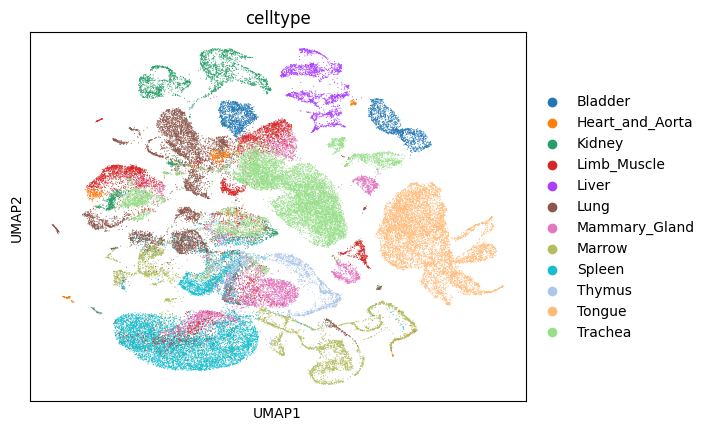

In [ ]:
encoded_muris.obs = muris.obs
sc.pl.umap(encoded_muris, color='celltype', title='Umap of encoded muris data')

/opt/miniconda3/envs/scdiffusion/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 18996 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


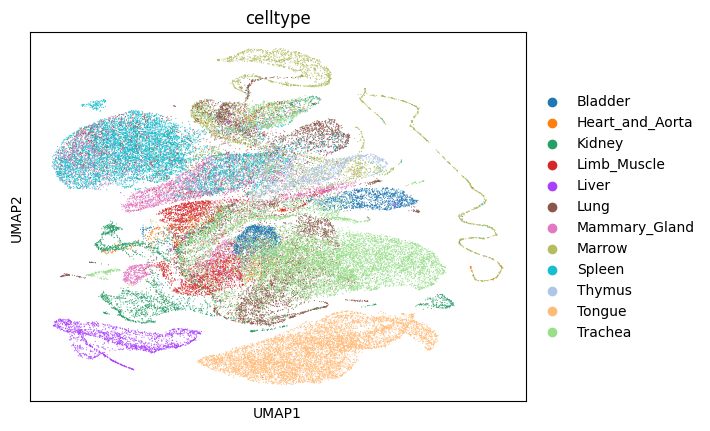

In [12]:
sc.pp.neighbors(muris, n_neighbors=10, n_pcs=20)
sc.tl.umap(muris)
sc.pl.umap(muris, color='celltype', title='Umap of muris data')

In [17]:
# Select subset of data for nb copula model
# take every 6th cell
muris_selected = muris.copy()[::6]
# take every 6th gene
muris_gene_selected = muris_selected[:,::6]
display(muris_selected.X)

<9501x18996 sparse matrix of type '<class 'numpy.float32'>'
	with 17862210 stored elements in Compressed Sparse Row format>

In [18]:
csc_X = csc_matrix(muris_gene_selected.X)
csc_muris_selected = ad.AnnData(csc_X, obs = muris_gene_selected.obs, var = muris_gene_selected.var)
csc_muris_selected.X

<9501x3166 sparse matrix of type '<class 'numpy.float32'>'
	with 2962593 stored elements in Compressed Sparse Column format>

In [19]:
# Fit NB copula model and simulate data
nbsim = nbc()
nbsim.fit(csc_muris_selected, "~ celltype", copula_groups = "celltype")
nbsamples = nbsim.sample(csc_muris_selected.obs)

/Users/malangtian/Documents/Research_Projects/scDesigner_project/scDesigner/scdesigner/src/scdesigner/data/group.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.list[idx]


/opt/miniconda3/envs/scdiffusion/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/miniconda3/envs/scdiffusion/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 3166 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


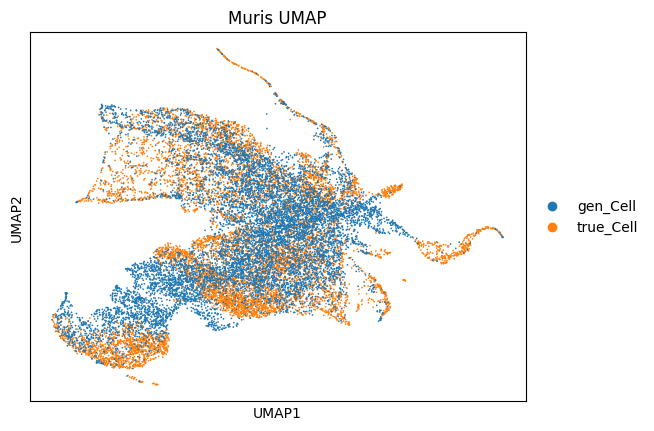

In [20]:
concat_data = ad.concat([muris_gene_selected, nbsamples], axis=0)
concat_data.obs['cell_name'] = [f"true_Cell" for i in range(muris_gene_selected.X.shape[0])]\
    +[f"gen_Cell" for i in range(nbsamples.X.shape[0])]

sc.pp.neighbors(concat_data, n_neighbors=10, n_pcs=20)
sc.tl.umap(concat_data)
sc.pl.umap(adata=concat_data,color="cell_name",size=6,title='Muris UMAP')

In [ ]:
sc.pp.log1p(muris_selected)

celltype = muris.obs['celltype']
gene_names = muris.var_names

/opt/miniconda3/envs/scdiffusion/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:413: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
# Load simulated muris data
npzfile=np.load('../output/simulated_samples/muris.npz',allow_pickle=True) 
sim_latent_muris = npzfile['cell_gen'][:muris_selected.X.shape[0]]
print(sim_latent_muris.shape)

# decode the simulated muris data

sim_muris = autoencoder(torch.tensor(sim_latent_muris).to(device),
                        return_decoded=True).cpu().detach().numpy()
sim_muris.shape

(9501, 128)


(9501, 18996)

plot UMAP

/opt/miniconda3/envs/scdiffusion/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/miniconda3/envs/scdiffusion/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 18996 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


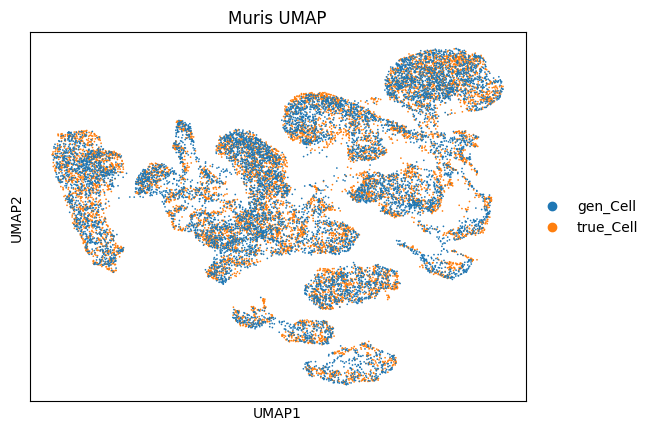

In [23]:
# nbsimulator and real data comparison
diffusion_concat_data = np.concatenate((muris_selected.X.toarray(), sim_muris),axis=0)
diffusion_concat_adata = ad.AnnData(diffusion_concat_data, dtype=np.float32)

diffusion_concat_adata.obs['cell_name'] = [f"true_Cell" for i in range(muris_selected.X.shape[0])]\
    +[f"gen_Cell" for i in range(sim_muris.shape[0])]

sc.pp.neighbors(diffusion_concat_adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(diffusion_concat_adata)
sc.pl.umap(adata=diffusion_concat_adata,color="cell_name",size=6,title='Muris UMAP')